# Simulated data
To illustrate some key points of the paper, generate data sampling from a multivariate normal distribution.
We sample from a 11-dimensional distribution, where all features have zero mean and unit variance, the first 10 (used as predictors in all the analyses we run) are orthogonal, and each of them has .2 correlation with the eleventh dimension (used as outcome). <br>
We simulate data iteratively, varyin the number of samples drawn. For each pass we fit OLS regression and cross-validated regression. <br> 
The purpose of these analyses is to illustrate the following points:
- **Increasing sample size** improves test performance and reduces risk of overfitting;
- For small sample sizes, we compare CV test R-squared and in-sample R-squared from OLS. CV test performance is a **more realistic estimate** of predictive performance and actual generalizability, while high in-sample R-squared is often an index of overfitting.

In [1]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
import seaborn as sns
from matplotlib import pyplot as plt

## Set parameters for simulation
(There's no particular reason behind using these rather than other values. In terms of the two main points made in this notebook, other values should return a similar picture.)

In [2]:
nr_feat = 10
r = .2

In [3]:
cov_mat = np.eye(nr_feat)
cov_mat = np.vstack((cov_mat, [.2] * nr_feat))
cov_mat = np.hstack((cov_mat, np.array([.2] * nr_feat + [1]).reshape(-1,1)))

## Set up cross-validation and OLS

In [4]:
sizes = [int(s) for s in np.geomspace(50, 10000, 50)]
K = 10
est_lr = LinearRegression()
kfolds = KFold(n_splits=K)

## Generate data and fit models
Iterate through a list of sample sizes, simulate data, then fit OLS and CV models. <br>
We store in-sample **r-squared** for the OLS model, and mean **r-squared** across folds for both training and validation sets for cross-validated models. <br>

In [15]:
np.array(cv_r2_test).std()

0.00725195607416843

In [6]:
nr_sim = 100
avg_train, avg_test, avg_reg, sd_train, sd_test, sd_reg = [], [], [], [], [], []

for idx, s in enumerate(sizes):
    print(idx)
    reg_r2, cv_r2_train, cv_r2_test = [], [], []    
    np.random.seed(idx)

    for n in range(nr_sim):
        # Preprocess data
        data = np.random.multivariate_normal([0] * (nr_feat + 1), cov_mat, size=s)
        X_sub, y_sub = data[:,:nr_feat], data[:,nr_feat]
        X2 = sm.add_constant(X_sub)
        # Fit model
        est = sm.OLS(y_sub, X2)
        m = est.fit()
        reg_r2.append(m.rsquared)
        # Cross-validated model
        cv_scores = cross_validate(est_lr, X_sub, y_sub, cv=kfolds, 
                                return_train_score=True)
        cv_r2_test.append(cv_scores['test_score'].mean())
        cv_r2_train.append(cv_scores['train_score'].mean())

    avg_train.append(np.array(cv_r2_train).mean())
    sd_train.append(np.array(cv_r2_train).std())
    avg_test.append(np.array(cv_r2_test).mean())
    sd_test.append(np.array(cv_r2_test).std())
    avg_reg.append(np.array(reg_r2).mean())
    sd_reg.append(np.array(reg_r2).std())
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Training and test performance in CV by sample size
As sample size increases, test performance increases. Training performance decreases, converging towards test performance.
Increasing sample size reduces the risk of overfitting.

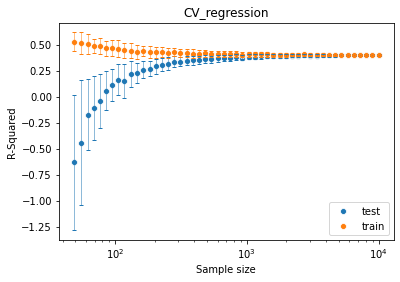

In [20]:
g = sns.scatterplot(sizes, avg_test, label='test')
g.errorbar(x=sizes, y=avg_test, yerr=sd_test, capsize=2, elinewidth=.5, ls='')
g2 = sns.scatterplot(sizes, avg_train, label='train')
g2.errorbar(x=sizes, y=avg_train, yerr=sd_train, capsize=2, elinewidth=.5, ls='')
plt.legend()
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('R-Squared')
plt.title('CV_regression')
plt.show()

## In-sample performance vs. test CV performance for small samples
For small samples, in-sample performance metrics from regression (overwhelmingly common metric of model performance in psychology) return an overly optimistic picture of actual performance and generalizability of the model. This is due to the fact that for small samples, the model tends to **overfit**. <br> On the contrary, cross-validated test performance yields lower and more realistic performance estimates, which helps calibrating inferences and claims made from the data and models.

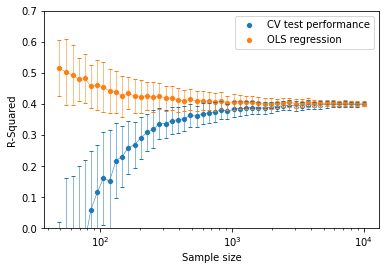

In [21]:
g = sns.scatterplot(sizes, avg_test, label='CV test performance')
g.errorbar(x=sizes, y=avg_test, yerr=sd_test, capsize=2, elinewidth=.5, linewidth=.5)
g2 = sns.scatterplot(sizes, avg_reg, label='OLS regression')
g2.errorbar(x=sizes, y=avg_reg, yerr=sd_reg, capsize=2, elinewidth=.5, linewidth=.5)
plt.legend()
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('R-Squared')
plt.ylim((0.0, 0.7))
plt.show()

## Interpreting internal parameters: LASSO vs. Ridge
In psychology, inference on mechanisms underlying phenomena is often drawn by interpreting parameter estimates for features of interest (and their significance) in causal terms. However, direct interpretation of parameter estimates can be misleading. Models using the same input features (but, for example, differring in optimization strategies or other aspects of parameter estimation) can achieve the same performance levels but attribute different weights to the various input features. <br>
One example of this are widely used regularization methods for regression: LASSO and ridge regression. These two methods are generally used in high-dimensional settings to prevent overfitting. Both methods do so by reducing variance and in both cases, this is achieved by adding a term is added to the loss function which penalizes models with large parameter estimates. Across the two methods, however, the penalty term differs. In practice, regression with LASSO penalty regularizes by forcing parameter estimates to zero, effectively corresponding to a feature selection method, while this is not the case in ridge regression. <br>
Often, (with adequate tuning of the regularization parameters alpha), the two methods yield comparable performance. Due to the nature of the regularization imposed to the model, however, parameter estimates differ (sometimes widely). In most cases there is no intrinsic reason to claim that one is most suited to modeling a certain phenomenon than the other: estimates produced by either model are thus equally "valid". This suggests that directly interpreting individual parameter estimates in terms of how strongly a certain feature influences the outcome variable can be tricky: estimates are conditional on which model is used, and different configurations of parameter estimates could model a certain phenomenon equally well.

In [22]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_validate

In [34]:
nr_feat = 100
cov_mat_highcorr = np.eye(nr_feat)
cov_mat_highcorr = np.vstack((cov_mat_highcorr, [.4] * nr_feat))
cov_mat_highcorr = np.hstack((cov_mat_highcorr, np.array([.4] * nr_feat + [1]).reshape(-1,1)))

In [35]:
np.random.seed(0)
data = np.random.multivariate_normal([0] * (nr_feat + 1), cov_mat_highcorr, size=10000)
X_sub, y_sub = data[:,:nr_feat], data[:,nr_feat]

In [36]:
np.random.seed(0)
test_size = round(X_sub.shape[0] / 100 * 70)
train_idx = np.random.randint(0, X_sub.shape[0], test_size)
test_idx = list(set(range(0, X_sub.shape[0])) - set(train_idx))
X = X_sub[train_idx, :]
y = y_sub[train_idx]
X_test = X_sub[test_idx, :]
y_test = y_sub[test_idx]

In [37]:
lasso_est = LassoCV(random_state=0, n_alphas=11).fit(X, y)
lasso_coefs = lasso_est.coef_
lasso_alpha = lasso_est.alpha_
mse_lasso = lasso_est.mse_path_[np.where(lasso_est.alphas_ == lasso_alpha)[0][0]].mean()

In [38]:
print(f'Lasso mse: {mse_lasso}')
print(f'Lasso alpha: {lasso_alpha}')

Lasso mse: 3.8218841405264516
Lasso alpha: 0.02164729146777953


In [39]:
np.random.seed(0)
ridge_est = RidgeCV(alphas=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 100, 1000, 5000], 
                    store_cv_values=True).fit(X, y)
ridge_coefs = ridge_est.coef_

In [40]:
errors = []
for i in range(ridge_est.cv_values_.shape[1]):
    err = ridge_est.cv_values_[:, i].mean()
    errors.append(err)
    if min(errors) == err:
        min_mse = err
        ridge_alpha = ridge_est.alphas[i]

In [41]:
print(f'Ridge mse: {min_mse}')
print(f'Ridge alpha: {ridge_alpha}')

Ridge mse: 3.79718217497751
Ridge alpha: 5000.0


In [42]:
print(f'LASSO R2 on test set: {lasso_est.score(X_test, y_test)}')
print(f'Ridge R2 on test set {ridge_est.score(X_test, y_test)}')

LASSO R2 on test set: 0.04429623232610913
Ridge R2 on test set 0.05087142919969834


In [43]:
print(f'LASSO MSE on test set: {np.power(lasso_est.predict(X_test) - y_test, 2).mean()}')
print(f'Ridge MSE on test set: {np.power(ridge_est.predict(X_test) - y_test, 2).mean()}')

LASSO MSE on test set: 3.8133773634460066
Ridge MSE on test set: 3.787141506932671


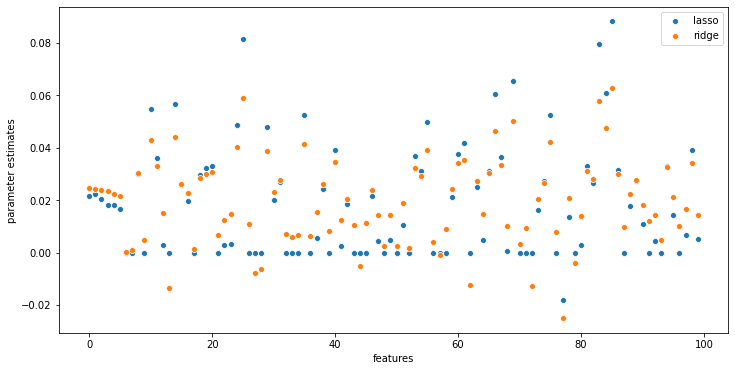

In [44]:
plt.figure(figsize=(12,6))
sns.scatterplot(range(X.shape[1]), lasso_coefs, label='lasso')
sns.scatterplot(range(X.shape[1]), ridge_coefs, label='ridge')
plt.xlabel('features')
plt.ylabel('parameter estimates')
plt.show()